In [1]:
import pandas as pd
import urllib
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

## Downloading dataset

In [2]:
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/volkamerlab/teachopencadd/master/teachopencadd/talktorials/T002_compound_adme/data/EGFR_compounds_lipinski.csv",
    "dataset.csv",
)

('dataset.csv', <http.client.HTTPMessage at 0x1f3095081f0>)

In [3]:
df = pd.read_csv('dataset.csv').drop(columns=["Unnamed: 0"])
df

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...
4630,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


In [4]:
df = df[["molecule_chembl_id", "smiles", "pIC50"]]
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 8.0, 0 otherwise
pIC50_cut_off = 8.0
df.loc[df[df.pIC50 >= pIC50_cut_off].index, "active"] = 1.0
df

C:\Users\mehra\AppData\Local\Temp\ipykernel_24228\1884176641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["active"] = np.zeros(len(df))


,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0
...,...,...,...,...
4630,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0
4631,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0
4632,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0
4633,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0


## Molecule encoding

In [217]:
import selfies as sf

def smiles_to_selfies(smiles):
    """
    Encode a molecule from a SMILES string into a SELFIES.
    
    Parameters
    ----------
        smiles : str
        The SMILES string defining the molecule.

    Returns
    -------
    string
        SELFIES representation
    """

    return sf.encoder(smiles)


def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [218]:
fp = 'maccs'
df["finger print"] = df["smiles"].apply(smiles_to_fp, method= fp)
df['selfies'] = df["smiles"].apply(smiles_to_selfies)
df

C:\Users\mehra\AppData\Local\Temp\ipykernel_24228\2644178769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["finger print"] = df["smiles"].apply(smiles_to_fp, method= fp)
C:\Users\mehra\AppData\Local\Temp\ipykernel_24228\2644178769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selfies'] = df["smiles"].apply(smiles_to_selfies)


,molecule_chembl_id,smiles,pIC50,active,finger print,selfies
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][=Branch1...
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][C][O][C][=C][C][=N][C][=N][C][Branch1][=N]...
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][C][C][C][=C][C][=C][Branch1][=...
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][Branch1]...
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][C][=C][C][=C][Branch1][=N][N][C][=C][C]...
...,...,...,...,...,...,...
4630,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][O][C][=C][C][Branch1][=Branch2][C][=C][Bra...
4631,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[O][=C][Branch1][C][O][/C][=C][/C][=C][C][=C][...
4632,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][=Branch2][C][=C][C][=C][N][=C]...
4633,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[N][#C][C][Branch1][Ring1][C][#N][C][C][=C][C]...


In [221]:
t = df['selfies'].to_list()
t

['[Br][C][=C][C][=C][C][Branch2][Ring1][=Branch1][N][C][=N][C][=N][C][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][Ring1][=C][Ring1][#Branch2][=C][Ring2][Ring1][Branch1]',
 '[C][C][O][C][=C][C][=N][C][=N][C][Branch1][=N][N][C][=C][C][=C][C][Branch1][C][Br][=C][Ring1][#Branch1][=C][Ring1][=C][C][=C][Ring2][Ring1][C][O][C][C]',
 '[C][N][Branch1][C][C][C][=C][C][=C][Branch1][=N][N][C][=C][C][=C][C][Branch1][C][Br][=C][Ring1][#Branch1][N][=C][N][=C][Ring1][=C][C][=N][Ring2][Ring1][C]',
 '[Br][C][=C][C][=C][C][Branch2][Ring1][Branch1][N][C][=N][C][=N][C][=C][C][NH1][C][=N][C][=Ring1][Branch1][C][=C][Ring1][=N][Ring1][=Branch2][=C][Ring2][Ring1][Ring2]',
 '[C][N][C][=C][C][=C][Branch1][=N][N][C][=C][C][=C][C][Branch1][C][Br][=C][Ring1][#Branch1][N][=C][N][=C][Ring1][=C][C][=N][Ring2][Ring1][C]',
 '[C][N][C][=N][C][=C][C][=N][C][=N][C][Branch1][=N][N][C][=C][C][=C][C][Branch1][C][Br][=C][Ring1][#Branch1][=C][Ring1][=C][C][=C][Ring2][Ring1][C][Ring2][Ring1][Branch1]',
 '[C][O][C][=C][C][=N

In [250]:
alphabet = sf.get_alphabet_from_selfies(df['selfies'].to_list())
alphabet.add('[nop]') # This is a special padding symbol
alphabet.add('.')
alphabet = list(sorted(alphabet))
voc = {s: i for i, s in enumerate(alphabet)}
pad_to_len = max(sf.len_selfies(s) for s in df["selfies"])

In [251]:
voc

{'.': 0,
 '[#Branch1]': 1,
 '[#Branch2]': 2,
 '[#C]': 3,
 '[#N]': 4,
 '[/C@@H1]': 5,
 '[/C@H1]': 6,
 '[/C]': 7,
 '[/Cl]': 8,
 '[/F]': 9,
 '[/N+1]': 10,
 '[/N]': 11,
 '[/O]': 12,
 '[=Branch1]': 13,
 '[=Branch2]': 14,
 '[=C]': 15,
 '[=N+1]': 16,
 '[=N-1]': 17,
 '[=N]': 18,
 '[=O+1]': 19,
 '[=O]': 20,
 '[=P]': 21,
 '[=Ring1]': 22,
 '[=Ring2]': 23,
 '[=S]': 24,
 '[B]': 25,
 '[Br-1]': 26,
 '[Br]': 27,
 '[Branch1]': 28,
 '[Branch2]': 29,
 '[C@@H1]': 30,
 '[C@@]': 31,
 '[C@H1]': 32,
 '[C@]': 33,
 '[C]': 34,
 '[Cl-1]': 35,
 '[Cl]': 36,
 '[F]': 37,
 '[I]': 38,
 '[N+1]': 39,
 '[NH1]': 40,
 '[N]': 41,
 '[O-1]': 42,
 '[OH0]': 43,
 '[O]': 44,
 '[P]': 45,
 '[Ring1]': 46,
 '[Ring2]': 47,
 '[S+1]': 48,
 '[S]': 49,
 '[Se]': 50,
 '[Si]': 51,
 '[Zn+2]': 52,
 '[\\C]': 53,
 '[\\F]': 54,
 '[\\N]': 55,
 '[\\O]': 56,
 '[\\S]': 57,
 '[nop]': 58}

In [253]:
def selfies_to_encoding(selfies):
  # try:
    label = sf.selfies_to_encoding(
      selfies=selfies,
      vocab_stoi=voc,
      pad_to_len=pad_to_len,
      enc_type="label"
    )
  # except:
  #   # print(selfies)
  #   return None
    return label

df['encoding'] = df["selfies"].apply(selfies_to_encoding)
df

C:\Users\mehra\AppData\Local\Temp\ipykernel_24228\1326549249.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoding'] = df["selfies"].apply(selfies_to_encoding)


,molecule_chembl_id,smiles,pIC50,active,finger print,selfies,encoding
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][=Branch1...,"[27, 34, 15, 34, 15, 34, 29, 46, 13, 41, 34, 1..."
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][C][O][C][=C][C][=N][C][=N][C][Branch1][=N]...,"[34, 34, 44, 34, 15, 34, 18, 34, 18, 34, 28, 1..."
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][C][C][C][=C][C][=C][Branch1][=...,"[34, 41, 28, 34, 34, 34, 15, 34, 15, 28, 18, 4..."
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][Branch1]...,"[27, 34, 15, 34, 15, 34, 29, 46, 28, 41, 34, 1..."
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][C][=C][C][=C][Branch1][=N][N][C][=C][C]...,"[34, 41, 34, 15, 34, 15, 28, 18, 41, 34, 15, 3..."
...,...,...,...,...,...,...,...
4630,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][O][C][=C][C][Branch1][=Branch2][C][=C][Bra...,"[34, 44, 34, 15, 34, 28, 14, 34, 15, 28, 46, 3..."
4631,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[O][=C][Branch1][C][O][/C][=C][/C][=C][C][=C][...,"[44, 15, 28, 34, 44, 7, 15, 7, 15, 34, 15, 28,..."
4632,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][=Branch2][C][=C][C][=C][N][=C]...,"[34, 41, 28, 14, 34, 15, 34, 15, 41, 15, 46, 1..."
4633,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[N][#C][C][Branch1][Ring1][C][#N][C][C][=C][C]...,"[41, 3, 34, 28, 46, 34, 4, 34, 34, 15, 34, 15,..."


## Baseline model

In [86]:
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curves_for_models(models, test_x, test_y, save_png=False, finger_print=None):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"), alpha=0.8)

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC - FP: {finger_print}")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"roc_auc_{finger_print}", dpi=300, bbox_inches="tight", transparent=True)
    return fig

def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = map(np.array, splits)

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

### Train-test split

In [158]:
from sklearn.model_selection import KFold, train_test_split

SEED = 22

X = np.vstack(df['finger print'])
y = np.vstack(df['active'])

(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.2, random_state=SEED)

splits = [X_train, X_test, y_train, y_test]

print("Training size:", len(X_train))
print("Test size:", len(y_test))

Training size: 3708
Test size: 927


(array([2996.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         712.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

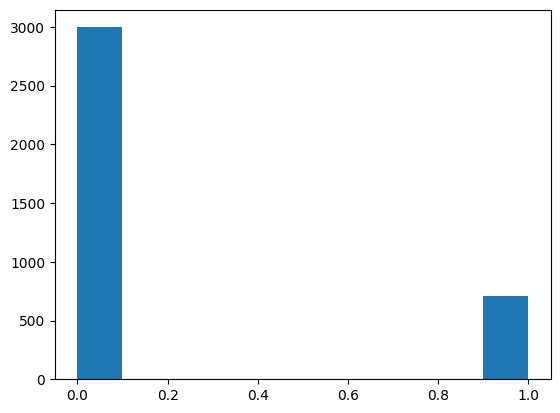

In [163]:
plt.hist(y_train)

In [150]:
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train,y_train)

In [160]:
# plt.hist(y_train)

### Random forest classifier

In [161]:
from sklearn.ensemble import RandomForestClassifier
# Set model parameter for random forest
param = {
    "n_estimators": 150,  # number of trees to grows
    "criterion": "entropy",  # loss function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [162]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

C:\Users\mehra\anaconda3\envs\valance\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Sensitivity: 0.51
Specificity: 0.94
AUC: 0.87


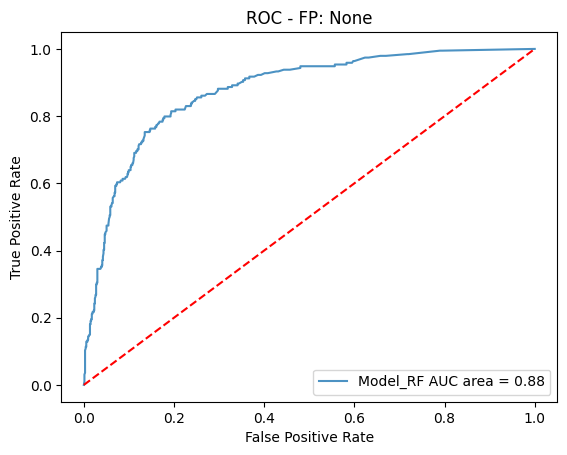

In [55]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, X_test, y_test);

### Support vector classifier

In [154]:
from sklearn import svm, metrics, clone
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

C:\Users\mehra\anaconda3\envs\valance\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Sensitivity: 0.35
Specificity: 0.98
AUC: 0.85


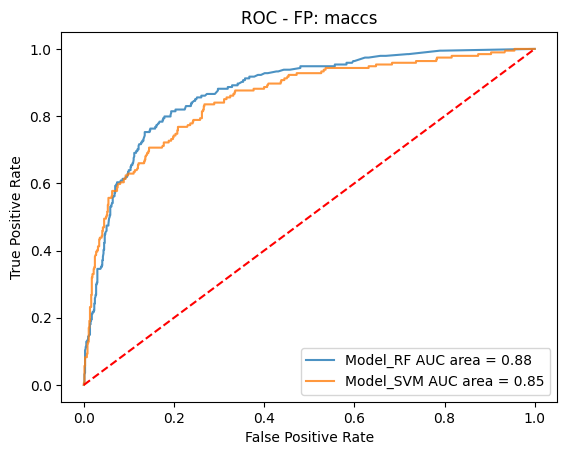

In [57]:
# Append SVM model
new_model = {"label": "Model_SVM", "model": model_SVM}

if not any(existing_model['label'] == new_model['label'] for existing_model in models):
    models.append(new_model)
# Plot roc curve
plot_roc_curves_for_models(models, X_test, y_test, save_png=True, finger_print=fp);

### Deep Neural Network

In [79]:
import tensorflow as tf
from dataclasses import dataclass

In [124]:
from imblearn.over_sampling import SMOTE

In [205]:
@dataclass
class Config:
    batch_size: int
    hidden_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(
                batch_size=32, 
                hidden_dim=16,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.3
               )

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='tanh', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(inputs)
    # x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 8, 
        activation='tanh', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    # x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='DNN')
    return model

In [206]:
tf.keras.backend.clear_session()
L = np.array(X_train).shape[1]
model_DNN = build_model(L)
opt = tf.optimizers.Adam(config.lr)
model_DNN.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

model_DNN.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 167)]             0         
                                                                 
 dense (Dense)               (None, 16)                2688      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 2725 (10.64 KB)
Trainable params: 2725 (10.64 KB)

In [211]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc',  # Metric to be monitored
                             factor=0.95,          # Factor by which the learning rate will be reduced
                             patience=20,         # No. of epochs with no improvement after which learning rate will be reduced
                             min_lr=0.00001,      # Lower bound on the learning rate
                             verbose=1) 

result = model_DNN.fit(
    np.array(X_train), np.array(y_train), 
    validation_data=(np.array(X_test), np.array(y_test)), 
    callbacks=[reduce_lr,
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=30)],
    epochs=200, batch_size=config.batch_size)

Epoch 1/200
116/116 [==============================] - 1s 7ms/step - loss: 0.3536 - auc: 0.8550 - binary_accuracy: 0.8331 - val_loss: 0.3729 - val_auc: 0.8493 - val_binary_accuracy: 0.8350 - lr: 6.3025e-04
Epoch 2/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3615 - auc: 0.8463 - binary_accuracy: 0.8323 - val_loss: 0.3746 - val_auc: 0.8512 - val_binary_accuracy: 0.8317 - lr: 6.3025e-04
Epoch 3/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3563 - auc: 0.8513 - binary_accuracy: 0.8417 - val_loss: 0.3839 - val_auc: 0.8508 - val_binary_accuracy: 0.8177 - lr: 6.3025e-04
Epoch 4/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3575 - auc: 0.8527 - binary_accuracy: 0.8336 - val_loss: 0.3709 - val_auc: 0.8494 - val_binary_accuracy: 0.8350 - lr: 6.3025e-04
Epoch 5/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3495 - auc: 0.8602 - binary_accuracy: 0.8371 - val_loss: 0.3725 - val_auc: 0.8491 - val_binary_accu

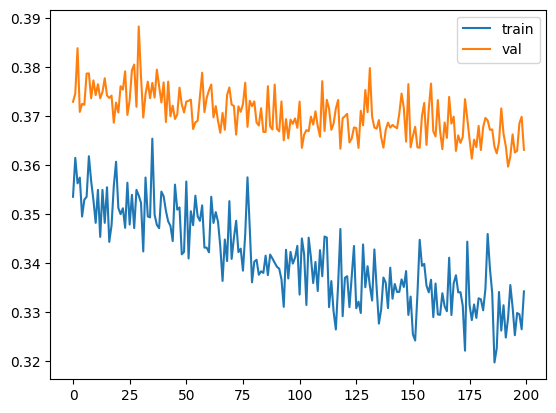

In [212]:
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='val')
plt.legend()

In [214]:
test_result = model_DNN.evaluate(np.array(X_test), np.array(y_test))

29/29 [==============================] - 0s 4ms/step - loss: 0.3631 - auc: 0.8607 - binary_accuracy: 0.8490


### Recurrent Neural Network

In [258]:
from sklearn.model_selection import KFold, train_test_split

SEED = 22

X = np.vstack(df['encoding'])
y = np.vstack(df['active'])

(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.2, random_state=SEED)

splits = [X_train, X_test, y_train, y_test]

print("Training size:", len(X_train))
print("Test size:", len(y_test))

Training size: 3708
Test size: 927


In [287]:
@dataclass
class LSTM_Config:
    vocab_size: int = len(voc)
    batch_size: int = 64
    buffer_size: int = 10000
    rnn_units: int = 32
    hidden_dim: int = 32
    embedding_dim: int = 64
    reg_strength: float = 0
    lr: float = 1e-3
    drop_rate: float = 0.35
    epochs: int = 150
    nmodels: int = 1
    adv_epsilon: float = 1e-3

lstm_config = LSTM_Config()


def build_LSTM_model(L=None):
    inputs = tf.keras.Input(shape=(L,))
    # input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=lstm_config.vocab_size,
                                  output_dim=lstm_config.embedding_dim,
                                  mask_zero=True)(inputs)
    e = tf.keras.layers.Dropout(config.drop_rate)(e)
    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_config.rnn_units))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(lstm_config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(lstm_config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        lstm_config.hidden_dim // 2,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(lstm_config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # var = tf.keras.layers.Dense(1, activation='softplus',
    #                             bias_constraint=tf.keras.constraints.MinMaxNorm(
    #                             min_value=1e-6, max_value=1000.0, rate=1.0, axis=0))(x)

    # out = tf.squeeze(tf.stack([mean, var], axis=-1))
    model = tf.keras.Model(inputs=inputs, outputs=output, name='LSTM')
    # partial_in = tf.keras.Model(inputs=inputs, outputs=e)
    # partial_out = tf.keras.Model(inputs=e, outputs=out)
    return model #, partial_in, partial_out

In [288]:
tf.keras.backend.clear_session()
L = np.array(X_train).shape[1]
model_LSTM = build_LSTM_model(L)
opt = tf.optimizers.Adam(lstm_config.lr)
model_LSTM.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 87)]              0         
                                                                 
 embedding (Embedding)       (None, 87, 64)            3776      
                                                                 
 dropout (Dropout)           (None, 87, 64)            0         
                                                                 
 bidirectional (Bidirection  (None, 87, 64)            24832     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 layer_normalization (Layer  (None, 64)                128    

In [289]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc',  # Metric to be monitored
                             factor=0.95,          # Factor by which the learning rate will be reduced
                             patience=20,         # No. of epochs with no improvement after which learning rate will be reduced
                             min_lr=0.00001,      # Lower bound on the learning rate
                             verbose=1) 

result = model_LSTM.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    callbacks=[reduce_lr,
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=30)],
    epochs=200, batch_size=config.batch_size)

Epoch 1/200
116/116 [==============================] - 96s 539ms/step - loss: 0.5149 - auc: 0.5018 - binary_accuracy: 0.8012 - val_loss: 0.5144 - val_auc: 0.5587 - val_binary_accuracy: 0.7907 - lr: 0.0010
Epoch 2/200
116/116 [==============================] - 47s 403ms/step - loss: 0.5007 - auc: 0.4871 - binary_accuracy: 0.8074 - val_loss: 0.5162 - val_auc: 0.5770 - val_binary_accuracy: 0.7907 - lr: 0.0010
Epoch 3/200
116/116 [==============================] - 46s 398ms/step - loss: 0.4946 - auc: 0.5069 - binary_accuracy: 0.8074 - val_loss: 0.5181 - val_auc: 0.6398 - val_binary_accuracy: 0.7907 - lr: 0.0010
Epoch 4/200
116/116 [==============================] - 46s 397ms/step - loss: 0.4902 - auc: 0.5371 - binary_accuracy: 0.8077 - val_loss: 0.4979 - val_auc: 0.7026 - val_binary_accuracy: 0.7907 - lr: 0.0010
Epoch 5/200
116/116 [==============================] - 46s 398ms/step - loss: 0.4792 - auc: 0.5995 - binary_accuracy: 0.8072 - val_loss: 0.4827 - val_auc: 0.6890 - val_binary_accur

In [290]:
model_LSTM.evaluate(X_test, y_test)

29/29 [==============================] - 4s 119ms/step - loss: 0.4306 - auc: 0.8430 - binary_accuracy: 0.8306


[0.4305938184261322, 0.8430225849151611, 0.8306364417076111]

In [ ]:
X_test

In [92]:
performance_measures = model_training_and_validation(model_DNN, "DNN", splits)

116/116 [==============================] - 4s 6ms/step - loss: 0.5054 - auc: 0.5543 - binary_accuracy: 0.7999


AttributeError: 'Functional' object has no attribute 'predict_proba'

In [ ]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [74]:
from rdkit.Chem import AllChem, Descriptors
# Define function to convert SMILES to descriptors
def smiles_to_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    desc = [Descriptors.MolWt(mol), Descriptors.NumRotatableBonds(mol), Descriptors.TPSA(mol)] + list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048))
    return desc

In [75]:
test_s = df.iloc()[0]['smiles']

In [76]:
features_s = np.array(smiles_to_desc(test_s))

In [73]:
features_s.shape

(2051,)

In [78]:
len(set(df['smiles']))

4635

In [91]:
X_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [123]:
!pip install imbalanced-learn

   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ---------------------------------------  235.5/235.6 kB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 4.8 MB/s eta 0:00:00
